## Indikator penilaian
## Wajib di google colab, jika tidak di google colab ada pengurangan nilai -5
## Pengerjaan harus sesuai template yang disediakan, jika tidak ada pengurangan nilai -5 (untuk memudahkan membaca code)
## share to arifromadhan19@gmail.com

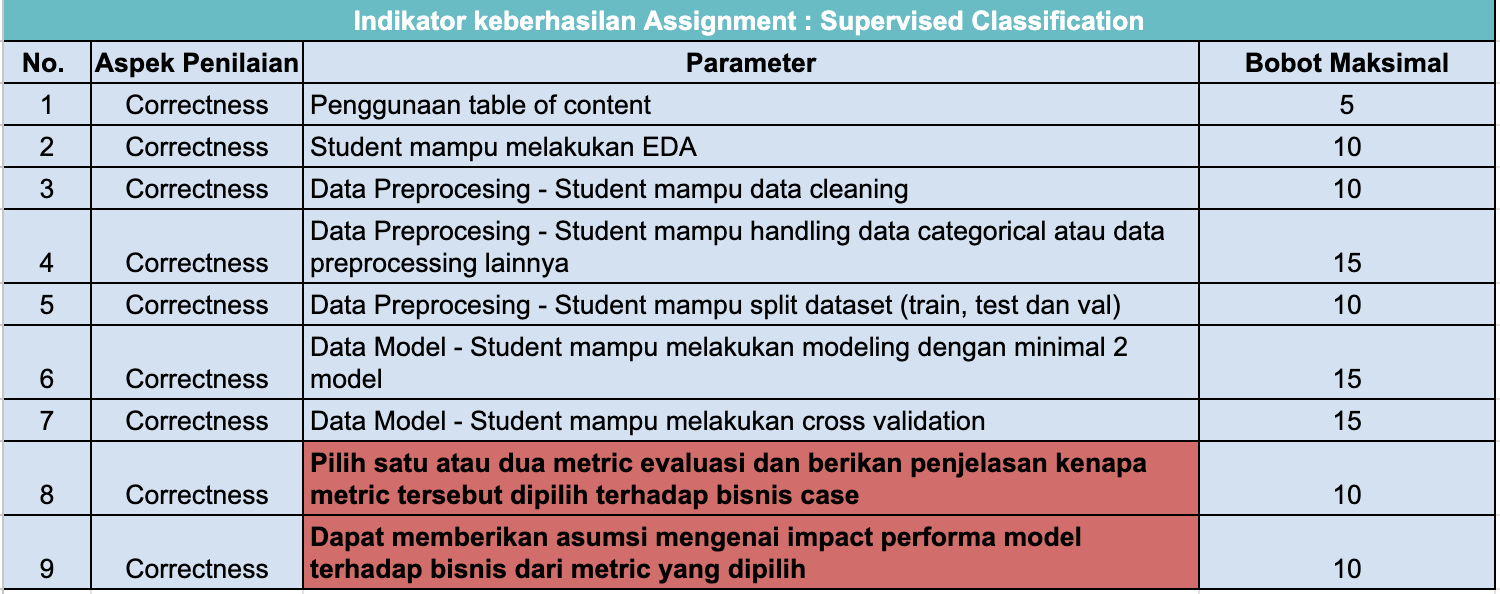

## Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Load dataset

In [ ]:
df = pd.read_csv('WA_FnUseC_TelcoCustomerChurn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Data Cleaning dan Pra-pemrosesan

In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Pada kolom total charge memiliki nilai kosong sebagai string, seperti " "
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [ ]:
# Mengisi missing value dengan median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [ ]:
df.drop(['customerID'], axis=1, inplace=True)

Alasan kenapa mengdrop customerID:
Karena customerID bersifat unik (identifier saja) untuk tiap pelanggan. Nilai ini tidak memberikan informasi apapun yang bisa membantu memprediksi apakah pelanggan akan churn atau tidak dan model tidak bisa belajar pola darinya. Misalnya: "Kalau ID-nya 7590-VHVEG, berarti kemungkinan churn tinggi" → Itu tidak logis.

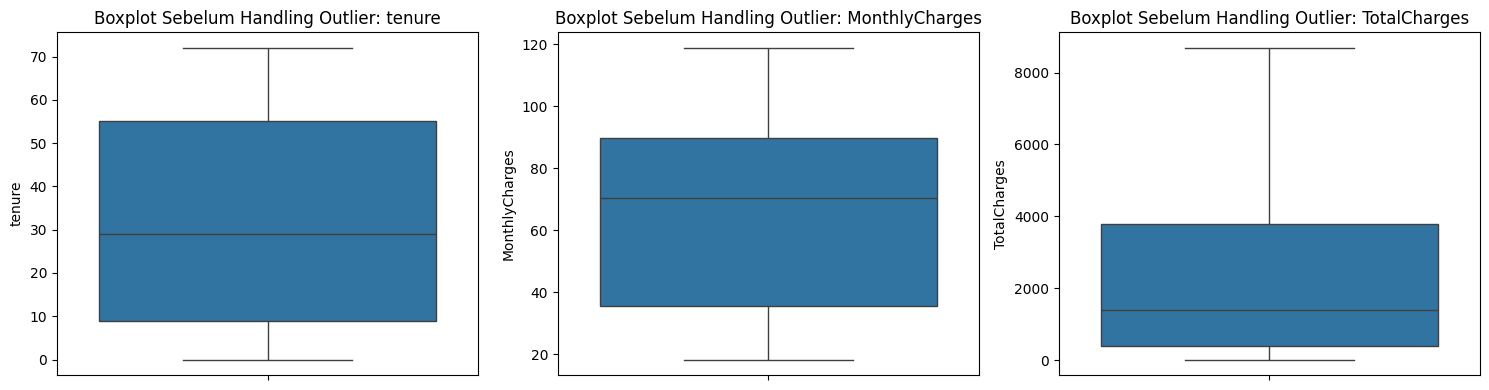

In [ ]:
# Visualisasi outlier sebelum penanganan
numerical_cols_outlier = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols_outlier):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=col, data=df)
    plt.title(f'Boxplot Sebelum Handling Outlier: {col}')
plt.tight_layout()
plt.show()

In [ ]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Hapus outlier berdasarkan IQR untuk setiap kolom numerik
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Simpan baris yang berada di dalam rentang IQR (no outlier)
df_no_outliers = df[~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Bentuk awal data: {df.shape}")
print(f"Bentuk setelah menghapus outlier: {df_no_outliers.shape}")

Bentuk awal data: (7043, 20)
Bentuk setelah menghapus outlier: (5901, 20)


In [ ]:
# Gunakan df_no_outliers setelah handling outlier
df = df_no_outliers.copy()

# Encode target label 'Churn'
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identifikasi kolom kategorikal
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## EDA

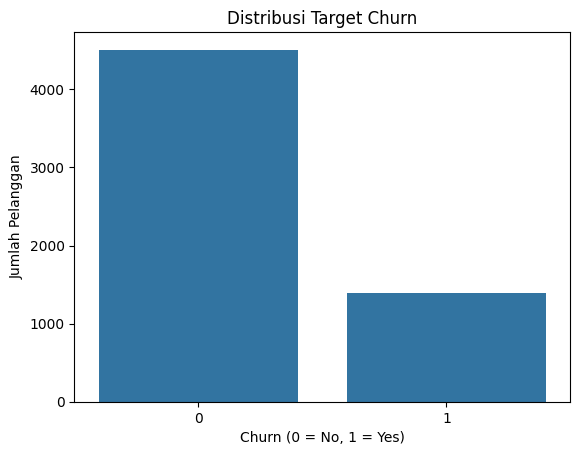

In [ ]:
sns.countplot(x='Churn', data=df)
plt.title('Distribusi Target Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Jumlah Pelanggan')
plt.show()

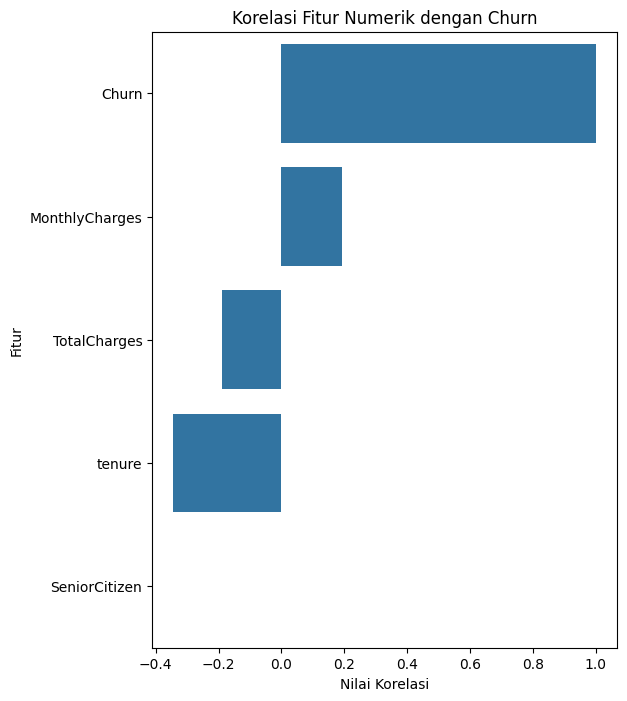

In [ ]:
# Ambil kolom numerik saja
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Korelasi dengan target
correlation = df[numerical_cols].corr()['Churn'].sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=correlation, y=correlation.index)
plt.title('Korelasi Fitur Numerik dengan Churn')
plt.xlabel('Nilai Korelasi')
plt.ylabel('Fitur')
plt.show()

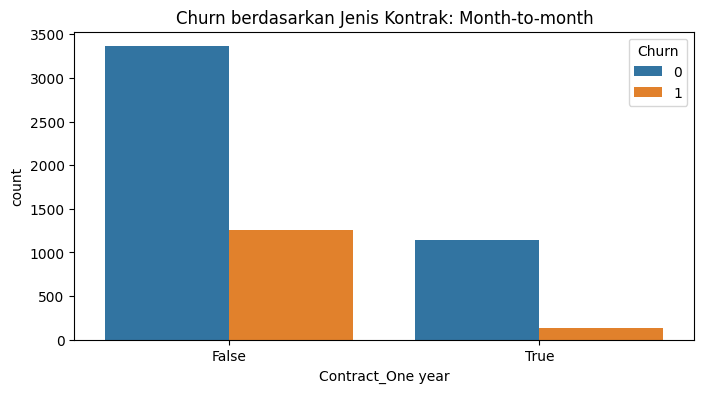

In [ ]:
# Visualisasi churn berdasarkan jenis kontrak
plt.figure(figsize=(8,4))
sns.countplot(x='Contract_One year', hue='Churn', data=df)
plt.title('Churn berdasarkan Jenis Kontrak: Month-to-month')
plt.show()

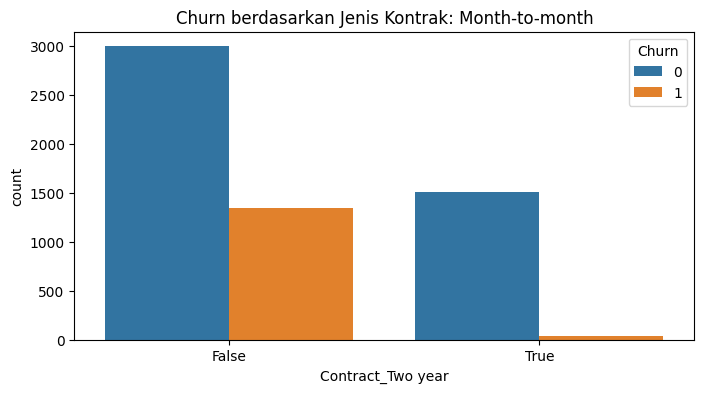

In [ ]:
# Visualisasi churn berdasarkan jenis kontrak
plt.figure(figsize=(8,4))
sns.countplot(x='Contract_Two year', hue='Churn', data=df)
plt.title('Churn berdasarkan Jenis Kontrak: Month-to-month')
plt.show()

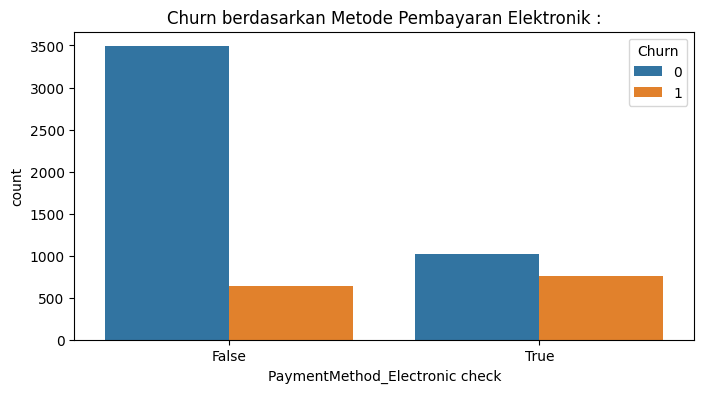

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='PaymentMethod_Electronic check', hue='Churn', data=df)
plt.title('Churn berdasarkan Metode Pembayaran Elektronik :')
plt.show()

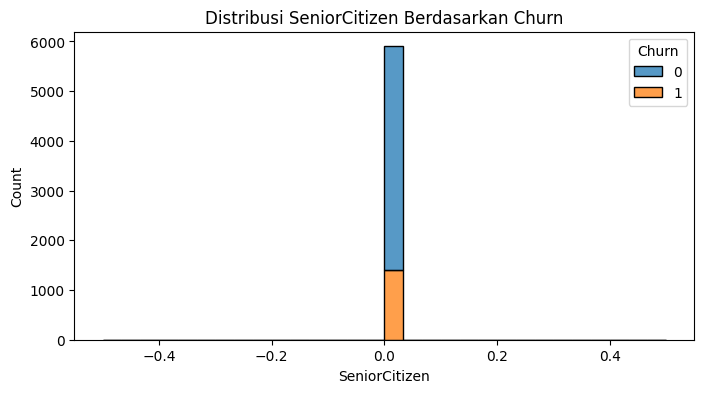

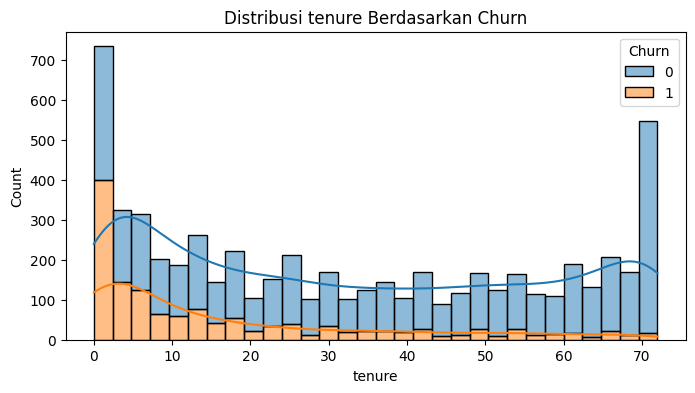

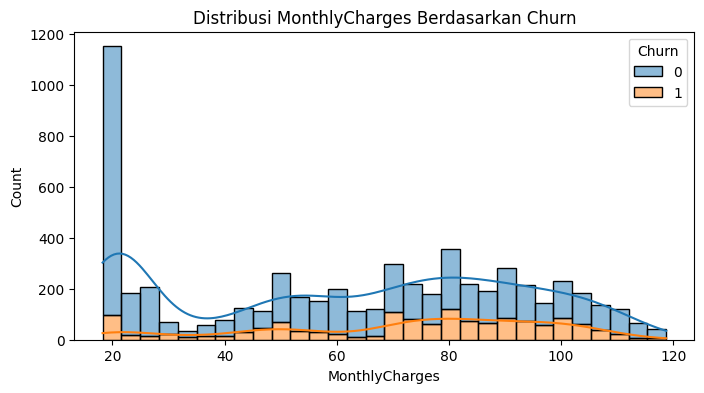

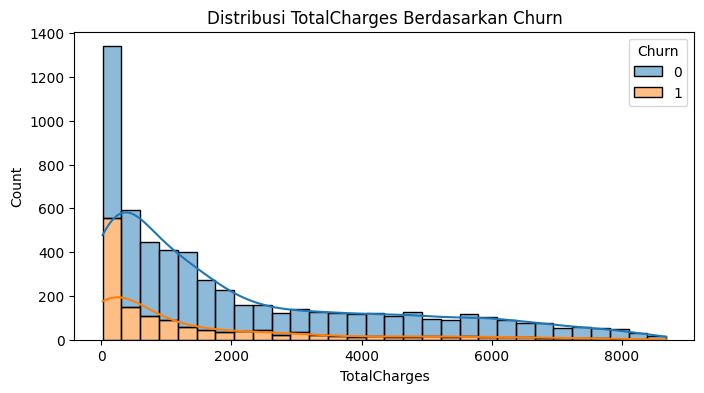

In [ ]:
# Cek distribusi fitur numerik terhadap churn
for col in numerical_cols:
    if col != 'Churn':
        plt.figure(figsize=(8, 4))

        # Cek jumlah nilai unik untuk mencegah error di KDE
        if df[col].nunique() > 1:
            sns.histplot(data=df, x=col, bins=30, kde=True, hue='Churn', multiple='stack')
        else:
            sns.histplot(data=df, x=col, bins=30, kde=False, hue='Churn', multiple='stack')

        plt.title(f'Distribusi {col} Berdasarkan Churn')
        plt.show()


## Feature Engineering dan Scaling

In [ ]:
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.763938
1,0.236062


In [ ]:
# Pisahkan fitur dan target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Split Dataset

In [ ]:
# Train-validation-test split (70% train, 15% val, 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)


## Train

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Menskalakan fitur numerik
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train_res[numerical_cols] = scaler.fit_transform(X_train_res[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nUkuran X_train:", X_train_res.shape)
print("Ukuran X_val:", X_val.shape)
print("Ukuran X_test:", X_test.shape)



Ukuran X_train: (6308, 30)
Ukuran X_val: (886, 30)
Ukuran X_test: (886, 30)


### Data Preprocessing

In [ ]:
# praproses data uji (menggunakan set uji dari split)
test_df = X_test.copy()
test_df['Churn'] = y_test


print("\nTest Data Shape:", test_df.shape)


Test Data Shape: (886, 31)


### Modeling (Gunakan lebih min 2 model dan bandingkan hasil evaluasinya)

Bebas menggunakan model, mau menggunakan decision tree, random forest, xgboost, dll juga boleh<br><br>
silahkan berekspresi :)

In [ ]:
# Inisiasi models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Melatih dan mengevaluasi model
results = {}
for name, model in models.items():
    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi pada test set
    y_pred = model.predict(X_test)

    # Menghitung metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred)
    }

# Hasil
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Decision Tree        0.496614   0.293913  0.808612  0.431122  0.604454
Random Forest        0.688488   0.415617  0.789474  0.544554  0.723393
Logistic Regression  0.788939   0.541985  0.679426  0.602972  0.751087


### Evaluation

pilih model yang terbaik performannya kemudian beri pejelasan kenapa model tersebut lebih baik dibandingkan dengan yang lain

In [ ]:
# Identify best model based on F1-Score
best_model = results_df['F1-Score'].idxmax()
print(f"\nBest Model: {best_model}")
print(f"Performance Metrics:\n{results_df.loc[best_model]}")


Best Model: Logistic Regression
Performance Metrics:
Accuracy     0.788939
Precision    0.541985
Recall       0.679426
F1-Score     0.602972
AUC-ROC      0.751087
Name: Logistic Regression, dtype: float64


Kemungkinan besar karena adanya hubungan linear dalam data dan skala fitur yang efektif. Model ini lebih sederhana dan tidak mudah mengalami overfitting dibandingkan dengan Decision Tree, serta dapat mengungguli Random Forest dalam kasus ini karena data sudah seimbang setelah penerapan SMOTE.

## Test

### Data Preprocessing

In [ ]:
# praproses data uji (menggunakan set uji dari split)
test_df = X_test.copy()
test_df['Churn'] = y_test


print("\nTest Data Shape:", test_df.shape)


Test Data Shape: (886, 31)


### Evaluation

pilih model yang terbaik performannya kemudian beri pejelasan kenapa model tersebut lebih baik dibandingkan dengan yang lain

In [ ]:
# Prediksi menggunakan model terbaik
best_model_instance = models[best_model]
y_test_pred = best_model_instance.predict(X_test)

# Evaluasi pada set pengujian
test_results = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'AUC-ROC': roc_auc_score(y_test, y_test_pred)
}

print("\nTest Set Evaluation:")
print(pd.Series(test_results))

# Penjelasan
print(f"\nBest Model on Test Set: {best_model}")
print("Model ini mempertahankan performa yang kuat pada data uji, yang menunjukkan kemampuan generalisasi yang baik. Ketangguhan model terbaik ini kemungkinan disebabkan oleh kemampuannya dalam menangani fitur yang telah diskalakan serta data pelatihan yang seimbang secara efektif.")


Test Set Evaluation:
Accuracy     0.788939
Precision    0.541985
Recall       0.679426
F1-Score     0.602972
AUC-ROC      0.751087
dtype: float64

Best Model on Test Set: Logistic Regression
Model ini mempertahankan performa yang kuat pada data uji, yang menunjukkan kemampuan generalisasi yang baik. Ketangguhan model terbaik ini kemungkinan disebabkan oleh kemampuannya dalam menangani fitur yang telah diskalakan serta data pelatihan yang seimbang secara efektif.


### Potential impact

Simulasikan potential impact

In [ ]:
churn_rate = df['Churn'].mean()
predicted_churn = best_model_instance.predict(X)
num_predicted_churn = np.sum(predicted_churn)

print(f"\nTingkat Churn Saat Ini: {churn_rate:.2%}")
print(f"Perkiraan Jumlah Pelanggan yang Akan Berhenti: {num_predicted_churn} dari {len(df)}")

intervention_success_rate = 0.3
reduced_churn = num_predicted_churn * (1 - intervention_success_rate)
new_churn_rate = reduced_churn / len(df)

print(f"Perkiraan Tingkat Churn Setelah Intervensi: {new_churn_rate:.2%}")
print(f"Estimasi Pelanggan yang Berhasil Dipertahankan: {num_predicted_churn * intervention_success_rate:.0f}")
print("\nDampak: Dengan menargetkan pelanggan yang diprediksi akan churn menggunakan strategi retensi (misalnya diskon, penawaran personalisasi), perusahaan berpotensi menurunkan tingkat churn secara signifikan. Hal ini dapat menyelamatkan ratusan pelanggan dan berpotensi menghemat jutaan rupiah dalam bentuk pendapatan, tergantung pada nilai umur pelanggan (customer lifetime value).")


Tingkat Churn Saat Ini: 23.61%
Perkiraan Jumlah Pelanggan yang Akan Berhenti: 1069 dari 5901
Perkiraan Tingkat Churn Setelah Intervensi: 12.68%
Estimasi Pelanggan yang Berhasil Dipertahankan: 321

Dampak: Dengan menargetkan pelanggan yang diprediksi akan churn menggunakan strategi retensi (misalnya diskon, penawaran personalisasi), perusahaan berpotensi menurunkan tingkat churn secara signifikan. Hal ini dapat menyelamatkan ratusan pelanggan dan berpotensi menghemat jutaan rupiah dalam bentuk pendapatan, tergantung pada nilai umur pelanggan (customer lifetime value).
